In [44]:
from functools import partial

import os
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime

from tabulate import tabulate
from timm.models.vision_transformer import Block
from model_mae import MaskedAutoencoder
from utils import MaskEmbed, get_1d_sincos_pos_embed, ActiveEmbed, Utils

eps = 1e-6

In [79]:
def mask_matrix(W, M, R):
    # Count the number of currently masked cells in M
    masked_count = torch.sum(M)
    print(f"Masked count = {masked_count}")
    
    # Calculate the desired number of additional masked cells
    total_cells = W.numel()
    required_masked_count = int(R * total_cells)
    additional_masked_count = max(required_masked_count - masked_count, 0)
    print(f"additional masked count = {additional_masked_count}")
    
    # Mask additional cells in W
    unmasked_indices = torch.nonzero(M)
    masked_indices = unmasked_indices[torch.randperm(unmasked_indices.size(0))[:additional_masked_count]]
    W[masked_indices[:, 0], masked_indices[:, 1]] = 0

    return W

In [101]:
def min_swaps(s):
 
    s2 = s.copy()
 
    # Reverse a string
    s2.reverse()
 
    i = 0
    j = 0
    result = 0
    n = len(s)
    while (i < n):
 
        j = i
 
        # Iterate till characters
        # of both the strings match
        while (s[j] != s2[i]):
            j += 1
 
            # Iterating until i=j
            # result will be j-i
        while (i < j):
            temp = s[j]
            s[j] = s[j - 1]
            s[j - 1] = temp
            j -= 1
            result += 1
 
        i += 1
 
    return result

# Example usage:
binary_string = "0100110"
min_ops = min_swaps(list(binary_string))
print("Minimum operations needed:", min_ops)

Minimum operations needed: 2


In [77]:
# Example usage:
# Define the shape of the matrix and the desired total masking fraction
rows, cols = 5, 5
R = 0.7

# Create the matrix W and the mask M (assuming initial mask is empty)
W = torch.rand((rows, cols))
print(f"Original Matrix = \n{W}")
M = torch.randint(0, 2, (rows, cols))
print(f"Original Mask = \n{M}")

Original Matrix = 
tensor([[0.4713, 0.5204, 0.5914, 0.6758, 0.9298],
        [0.6289, 0.8794, 0.3859, 0.2683, 0.4251],
        [0.1006, 0.1056, 0.4275, 0.9284, 0.5244],
        [0.9905, 0.5171, 0.2353, 0.7575, 0.4362],
        [0.4341, 0.0786, 0.1295, 0.4376, 0.9160]])
Original Mask = 
tensor([[0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [1, 0, 1, 0, 1],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])


In [72]:
unmasked_inds = torch.nonzero(M)
unmasked_inds.size()

torch.Size([12, 2])

In [75]:
torch.randperm(unmasked_inds.size(0))[:2]

tensor([10,  7])

In [80]:
# Mask the matrix W while maintaining the specified total masking fraction
W_ = mask_matrix(W, M, R)
print(W_)
# # Print the resulting matrix W
# print("Masked Matrix:")
# print(W)

Masked count = 9
additional masked count = 8
tensor([[0.4713, 0.5204, 0.5914, 0.0000, 0.9298],
        [0.6289, 0.0000, 0.3859, 0.0000, 0.4251],
        [0.0000, 0.1056, 0.0000, 0.9284, 0.5244],
        [0.0000, 0.5171, 0.2353, 0.0000, 0.4362],
        [0.4341, 0.0786, 0.1295, 0.4376, 0.0000]])


In [36]:
import numpy as np

def euclidean_distance(vector1, vector2):
    """
    Compute the Euclidean distance between two vectors.
    
    Parameters:
    vector1 (numpy.ndarray): First vector.
    vector2 (numpy.ndarray): Second vector.
    
    Returns:
    float: Euclidean distance between the two vectors.
    """
    # Ensure both vectors are numpy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    
    # Compute the squared differences between corresponding elements of the two vectors
    squared_diff = (vector1 - vector2) ** 2
    
    # Sum the squared differences and take the square root to get the Euclidean distance
    euclidean_dist = np.sqrt(np.sum(squared_diff))
    
    return euclidean_dist

# Example usage:
vector1 = [5, 3, 2, 0]
vector2 = [50, 30, 20, 0]
vector3 = [500, 300, 200, 0]
distance1 = euclidean_distance(vector1, vector2)
distance2 = euclidean_distance(vector1, vector3)
print("Euclidean distance:", distance2)


Euclidean distance: 610.2769862939286


In [37]:
import numpy as np

def cosine_similarity(vector1, vector2):
    """
    Compute the cosine similarity between two vectors.
    
    Parameters:
    vector1 (numpy.ndarray): First vector.
    vector2 (numpy.ndarray): Second vector.
    
    Returns:
    float: Cosine similarity between the two vectors.
    """
    # Compute dot product
    dot_product = np.dot(vector1, vector2)
    
    # Compute magnitudes
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    
    # Compute cosine similarity
    cosine_sim = dot_product / (magnitude1 * magnitude2)
    
    return cosine_sim

similarity = cosine_similarity(vector1, vector3)
print("Cosine similarity:", similarity)


Cosine similarity: 1.0


In [30]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

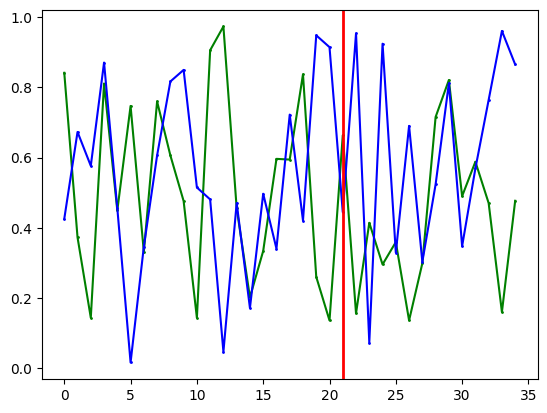

In [31]:
predictions = torch.rand(32, 35, 8)
dates = np.arange(predictions.shape[1])
sample_id = 1
masked_ts = torch.rand(32, 35, 8)

plt.plot(dates, predictions[sample_id, :, 0], label='Predictions TS', marker='o', linestyle='-', markersize=1,
                        color='green')
plt.plot(dates, masked_ts[sample_id, :, 0], label='Original TS', marker='o', linestyle='-', markersize=1, 
         color='blue')
# ax.plot(dates, masked_ts[sample_id, :, 0], label='Original Masked TS', marker='o', linestyle='-', markersize=1,
#          markerfacecolor='yellow', markeredgecolor='yellow', color='yellow', alpha=0.9)
plt.axvline(x=21, color='r', linestyle='-', linewidth=2)

In [7]:
lake_names = ['FCR_modeled', 'FCR_Observed', 'Sunapee']
index = [1, 2]
lake_names[index]

TypeError: list indices must be integers or slices, not list

In [8]:
train_start = np.random.choice(10, 1) # computing starting index to shift the window
val_start = np.random.choice(12, 1)
train_idx = np.arange(train_start, train_start+5*3+1, 1)
val_idx = np.arange(val_start, val_start+5*3+1, 1)

plt_idx = np.floor(np.linspace(2, 5-1, 4))

/tmp/ipykernel_42019/2121606930.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_idx = np.arange(train_start, train_start+5*3+1, 1)
/tmp/ipykernel_42019/2121606930.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_idx = np.arange(val_start, val_start+5*3+1, 1)


In [15]:
train_start

array([8])

In [11]:
val_start

array([10])

In [12]:
plt_idx

array([2., 2., 3., 4.])

In [13]:
val_idx

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [20]:
train_idx

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [437]:
df = pd.read_csv('./data/TransferLearningData.csv')

/tmp/ipykernel_31893/3104347854.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/TransferLearningData.csv')


In [9]:
unique_lakes = df.Lake.unique()

In [446]:
mm = torch.rand(2,2)

In [447]:
mm

tensor([[0.1841, 0.4021],
        [0.8591, 0.6875]])

In [450]:
x = torch.rand(10)
x

tensor([0.5144, 0.5055, 0.4479, 0.9672, 0.7137, 0.9113, 0.5764, 0.1380, 0.9339,
        0.9932])

In [454]:
x_ = torch.where(x<0.6, torch.tensor(float('nan')), x)
x_

tensor([   nan,    nan,    nan, 0.9672, 0.7137, 0.9113,    nan,    nan, 0.9339,
        0.9932])

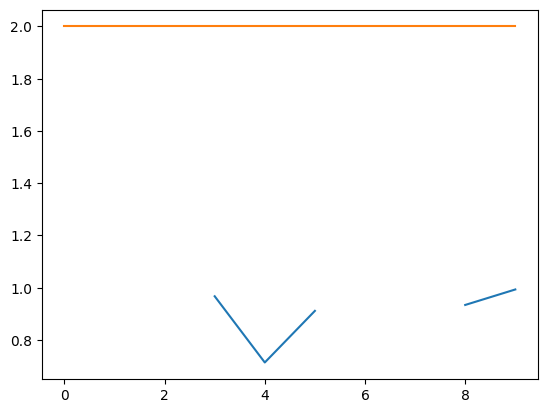

In [456]:
plt.plot(list(range(10)), x_.numpy())
plt.plot(list(range(10)), [2]*10)

In [ ]:
og_masked_ts = torch.where(og_masked_ts==0, torch.tensor(float('nan')).to(self.device), og_masked_ts)

In [428]:
mean = mm.mean()
std = mm.std()

In [429]:
mm_ = (mm-mean)/std
mm_

tensor([[ 0.8318,  0.1335],
        [ 0.4725, -1.4377]])

In [433]:
mm.min()

tensor(0.1274)

In [430]:
alpha = -mean/std

In [432]:
alpha

tensor(-1.7943)

In [435]:
torch.clamp(mm_, min=0.02)

tensor([[0.8318, 0.1335],
        [0.4725, 0.0200]])

In [436]:
mm_

tensor([[ 0.8318,  0.1335],
        [ 0.4725, -1.4377]])

In [414]:
binary_mask = torch.randint(0, 2, (4, 4))

In [424]:
(binary_mask<=0).any()

tensor(True)

In [415]:
binary_mask

tensor([[1, 1, 0, 0],
        [0, 1, 1, 1],
        [1, 0, 1, 0],
        [0, 1, 1, 1]])

In [416]:
binary_mask_2 = torch.randint(0, 2, (4, 4))

In [417]:
binary_mask_2

tensor([[0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 1],
        [1, 1, 1, 1]])

In [419]:
torch.logical_or(binary_mask, binary_mask_2)*1

tensor([[1, 1, 0, 0],
        [0, 1, 1, 1],
        [1, 0, 1, 1],
        [1, 1, 1, 1]])

In [358]:
xc = torch.rand((2, 2, 4))

In [359]:
xc

tensor([[[0.0096, 0.0355, 0.2253, 0.6261],
         [0.3929, 0.7018, 0.2138, 0.3977]],

        [[0.5771, 0.8895, 0.8952, 0.9142],
         [0.6994, 0.2295, 0.0382, 0.0275]]])

In [361]:
xc[0, 0] = np.nan

In [362]:
xc

tensor([[[   nan,    nan,    nan,    nan],
         [0.3929, 0.7018, 0.2138, 0.3977]],

        [[0.5771, 0.8895, 0.8952, 0.9142],
         [0.6994, 0.2295, 0.0382, 0.0275]]])

In [363]:
mean = torch.nanmean(xc, dim=(0, 1))[None, None, :]

In [364]:
mean

tensor([[[0.5565, 0.6069, 0.3824, 0.4464]]])

In [367]:
mask = torch.isnan(xc)
mask

tensor([[[ True,  True,  True,  True],
         [False, False, False, False]],

        [[False, False, False, False],
         [False, False, False, False]]])

In [372]:
filtered_data = xc.clone()

In [375]:
filtered_data[mask] = 0

In [379]:
filtered_data

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.3929, 0.7018, 0.2138, 0.3977]],

        [[0.5771, 0.8895, 0.8952, 0.9142],
         [0.6994, 0.2295, 0.0382, 0.0275]]])

In [392]:
filtered_data.shape

torch.Size([2, 2, 4])

In [395]:
((1-(mask*1))*((filtered_data - mean)**2))

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [0.0268, 0.0090, 0.0284, 0.0024]],

        [[0.0004, 0.0798, 0.2630, 0.2188],
         [0.0204, 0.1424, 0.1185, 0.1755]]])

In [396]:
((1-(mask*1))*((filtered_data - mean)**2)).sum(dim=(0, 1))

tensor([0.0476, 0.2313, 0.4099, 0.3967])

In [401]:
(((1-(mask*1))*((filtered_data - mean)**2)).sum(dim=(0, 1)))/torch.sum((1-mask*1), dim=(0, 1))

tensor([0.0159, 0.0771, 0.1366, 0.1322])

In [407]:
std = torch.sqrt((((1-(mask*1))*((filtered_data - mean)**2)).sum(dim=(0, 1)))/torch.sum((1-mask*1), dim=(0, 1)))[None, None, :]
std

tensor([[[0.1260, 0.2776, 0.3696, 0.3636]]])

In [408]:
std.shape

torch.Size([1, 1, 4])

In [406]:
(xc-mean)/std

tensor([[[    nan,     nan,     nan,     nan],
         [-1.2983,  0.3417, -0.4561, -0.1341]],

        [[ 0.1636,  1.0176,  1.3873,  1.2863],
         [ 1.1347, -1.3593, -0.9313, -1.1522]]])

In [ ]:
variance = torch.sum(((filtered_data - mean) ** 2)) / torch.sum(~mask)

In [253]:
x = torch.rand((32, 35, 8, 8))
x.shape

torch.Size([32, 35, 8, 8])

In [248]:
pe = nn.Parameter(torch.zeros(1, 35, 8), requires_grad=False)

In [249]:
pe.shape

torch.Size([1, 35, 8])

In [254]:
pe_embeds = [x[:, :, i, :] + pe for i in range(8)]

In [ ]:
torch.stack(pe_embeds, dim=)

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        if causal_mask:
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        output = weight @ v
        output = output.transpose(1, 2)
        output = output.reshape(input_shape)
        output = self.out_proj(output)
        return output

In [9]:
sa = SelfAttention(n_heads=2, d_embed=64)

In [10]:
x = torch.rand((4, 10, 64))

In [12]:
attn_map = sa(x)
attn_map.shape

torch.Size([4, 10, 64])

In [15]:
class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        self.k_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.v_proj = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads
    
    def forward(self, x, y):
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        output = weight @ v
        output = output.transpose(1, 2).contiguous()
        output = output.view(input_shape)
        output = self.out_proj(output)
        return output

In [22]:
ca = CrossAttention(n_heads=2, d_embed=64, d_cross=64)

In [23]:
query = torch.rand((8, 10, 64))
key = torch.rand((8, 10, 64))

In [25]:
weighted_vector = ca(query, key)

In [26]:
weighted_vector.shape

torch.Size([8, 10, 64])

In [ ]:
'''
TODO

1. 
'''

In [3]:
'''
Let's work on 1 window
'''

B = 32 # batch size
L = 1 # number of patches=1 (in our case)
W = 35 # window size
V = 8 # total num of features
D = 8 # Dimension of each feature

x = torch.rand((B, W, V, D))

In [4]:
class EmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(EmbeddingModel, self).__init__()
        # self.embeddings = nn.ModuleList([nn.Linear(1, embedding_dim) for _ in range(input_dim)])
        self.embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, embedding_dim),
                nn.LayerNorm(embedding_dim)
            )
            for _ in range(input_dim)
        ])

    def forward(self, x):
        embedded_features = [emb_layer(x[:, :, i].unsqueeze(-1)) for i, emb_layer in enumerate(self.embeddings)]
        embedded_features = torch.stack(embedded_features, dim=2)
        # embedded_features = embedded_features.transpose(1,2)
        
        return embedded_features

In [5]:
z = torch.rand((B, W, V))
z.shape

torch.Size([32, 35, 8])

In [6]:
input_dim = V  # Number of input features
embedding_dim = D  # Dimensionality of the embeddings
feat_emb = EmbeddingModel(input_dim, embedding_dim)

In [7]:
z_ = feat_emb(z)
z_.shape

torch.Size([32, 35, 8, 8])

In [8]:
x = x.squeeze()
x.shape

torch.Size([32, 35, 8, 8])

In [9]:
x = x.view(-1, V, D)
x.shape

torch.Size([1120, 8, 8])

In [20]:
nan_mask = torch.randint(0, 2, (B, W, V))

In [21]:
nan_mask = nan_mask.squeeze()
nan_mask.shape

torch.Size([32, 35, 8])

In [29]:
nan_mask = nan_mask.view(-1, V)
nan_mask.shape

torch.Size([1120, 8])

In [30]:
x[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2814, 0.9562, 0.3659, 0.5255, 0.6371, 0.4674, 0.1314, 0.2908],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4919, 0.5154, 0.9586, 0.2108, 0.3786, 0.8156, 0.9743, 0.4213],
        [0.1079, 0.5608, 0.6248, 0.8993, 0.9604, 0.1367, 0.4323, 0.9206],
        [0.6554, 0.9808, 0.6634, 0.8598, 0.0472, 0.5258, 0.8378, 0.1297],
        [0.9453, 0.8824, 0.2293, 0.2752, 0.2254, 0.2755, 0.1857, 0.2364],
        [0.4650, 0.5668, 0.0026, 0.3413, 0.9573, 0.2265, 0.1442, 0.9405]])

In [31]:
x = x*nan_mask.unsqueeze(-1)

In [32]:
nan_mask[0]

tensor([0, 0, 1, 1, 1, 1, 0, 0])

In [33]:
x[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4919, 0.5154, 0.9586, 0.2108, 0.3786, 0.8156, 0.9743, 0.4213],
        [0.1079, 0.5608, 0.6248, 0.8993, 0.9604, 0.1367, 0.4323, 0.9206],
        [0.6554, 0.9808, 0.6634, 0.8598, 0.0472, 0.5258, 0.8378, 0.1297],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [40]:
var_query = nn.Parameter(torch.zeros(1, 1, D), requires_grad=True)

In [41]:
var_query = var_query.repeat_interleave(B*W, dim=0)
var_query.shape

torch.Size([1120, 1, 8])

In [26]:
mhca = nn.MultiheadAttention(embed_dim=D, num_heads=2, batch_first=True)

In [94]:
mhca_ = nn.MultiheadAttention(embed_dim=8, num_heads=2, batch_first=True)

In [96]:
cls = torch.rand(1,8,8)
mask, weights = mhca_(cls, cls, cls)

In [97]:
mask.shape

torch.Size([1, 8, 8])

In [27]:
attn_out_wo_mask, _ = mhca(var_query, x, x)

In [34]:
attn_out_w_mask, _ = mhca(var_query, x, x, key_padding_mask=nan_mask)

In [35]:
attn_out_w_mask.squeeze().shape

torch.Size([1120, 8])

In [36]:
attn_out_wo_mask.squeeze().shape

torch.Size([1120, 8])

In [37]:
attn_out_wo_mask = attn_out_wo_mask.view(B, W, D)
attn_out_w_mask = attn_out_w_mask.view(B, W, D)

In [38]:
attn_out_wo_mask.shape

torch.Size([32, 35, 8])

In [39]:
attn_out_w_mask.shape

torch.Size([32, 35, 8])

In [125]:
'''
attn with mask
'''
attn_out_w_mask

tensor([[[ 0.1415,  0.1202, -0.3001,  0.3066,  0.2868, -0.2808, -0.1156,
           0.1219]],

        [[ 0.1951,  0.0761, -0.2991,  0.4110,  0.4697, -0.2817, -0.0990,
           0.2040]],

        [[ 0.0201,  0.1065, -0.3220,  0.2090,  0.3435, -0.1929, -0.1060,
           0.2066]]], grad_fn=<TransposeBackward0>)

In [126]:
'''
attn without mask
'''
attn_out_wo_mask

tensor([[[ 0.1192,  0.1012, -0.2526,  0.2582,  0.2415, -0.2364, -0.0973,
           0.1026]],

        [[ 0.1643,  0.0641, -0.2518,  0.3460,  0.3954, -0.2372, -0.0834,
           0.1717]],

        [[ 0.0170,  0.0897, -0.2711,  0.1760,  0.2892, -0.1624, -0.0893,
           0.1740]]], grad_fn=<TransposeBackward0>)

In [256]:
embed_dim = 8
seq = 10
num_feats = 4

In [257]:
assert embed_dim % 2 == 0

In [258]:
omega = np.arange(embed_dim // 2, dtype=np.float64)

In [259]:
omega

array([0., 1., 2., 3.])

In [260]:
omega /= embed_dim / 2.

In [261]:
omega

array([0.  , 0.25, 0.5 , 0.75])

In [262]:
omega = 1. / 10000**omega  # (D/2,)

In [263]:
omega

array([1.   , 0.1  , 0.01 , 0.001])

In [264]:
pos = np.arange(seq)  # (M,)

In [269]:
feat = np.arange(num_feats)

In [265]:
pos

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [270]:
feat

array([0, 1, 2, 3])

In [266]:
pos_embed = np.zeros((seq, num_feats, embed_dim))

In [268]:
pos_embed.shape

(10, 4, 8)

In [108]:
for f in range(num_feats):
    pos_embed_seq = np.einsum('s,d->sd', pos, omega)  # (S, D/2), outer product
    emb_sin_seq = np.sin(pos_embed_seq)  # (S, D/2)
    emb_cos_seq = np.cos(pos_embed_seq)  # (S, D/2)
    pos_embed[:, f, :] = np.concatenate([emb_sin_seq, emb_cos_seq], axis=1)  # (S, D)

In [115]:
pe = torch.rand((1,35,8))
x = torch.rand(32, 35, 8, 8)

In [131]:
torch.stack([x[:, :, i, :] + pe for i in range(8)], dim=3)[0][0]

tensor([[0.8819, 0.9968, 0.7453, 1.0841, 0.9592, 0.3966, 0.9314, 0.4672],
        [0.9646, 0.9634, 1.4716, 1.0069, 1.6804, 1.3152, 1.3040, 1.4445],
        [0.9868, 0.7730, 0.7721, 0.2173, 0.9213, 1.1567, 0.4881, 0.7117],
        [1.6482, 1.4606, 1.5537, 1.7330, 1.0112, 1.1914, 1.7202, 1.3683],
        [0.4092, 0.9277, 1.0662, 0.8699, 0.3502, 0.4045, 0.9308, 1.1306],
        [0.5459, 0.7446, 0.9123, 0.7976, 0.8152, 1.2543, 0.7397, 1.1991],
        [0.8464, 1.5842, 0.8164, 1.2322, 1.5953, 1.4502, 1.2255, 1.5479],
        [1.1683, 0.7840, 1.3271, 1.3315, 0.8734, 1.0312, 1.3471, 1.0988]])

In [114]:
pos_embed[1]

array([[0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ],
       [0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ],
       [0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ],
       [0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ]])

In [78]:
out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

In [79]:
out

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [2.e+00, 2.e-01, 2.e-02, 2.e-03],
       [3.e+00, 3.e-01, 3.e-02, 3.e-03],
       [4.e+00, 4.e-01, 4.e-02, 4.e-03],
       [5.e+00, 5.e-01, 5.e-02, 5.e-03],
       [6.e+00, 6.e-01, 6.e-02, 6.e-03],
       [7.e+00, 7.e-01, 7.e-02, 7.e-03],
       [8.e+00, 8.e-01, 8.e-02, 8.e-03],
       [9.e+00, 9.e-01, 9.e-02, 9.e-03]])

In [80]:
out.shape

(10, 4)

In [81]:
emb_sin = np.sin(out) # (M, D/2)

In [82]:
emb_sin.shape

(10, 4)

In [83]:
emb_cos = np.cos(out) # (M, D/2)
emb_cos

array([[ 1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.54030231,  0.99500417,  0.99995   ,  0.9999995 ],
       [-0.41614684,  0.98006658,  0.99980001,  0.999998  ],
       [-0.9899925 ,  0.95533649,  0.99955003,  0.9999955 ],
       [-0.65364362,  0.92106099,  0.99920011,  0.999992  ],
       [ 0.28366219,  0.87758256,  0.99875026,  0.9999875 ],
       [ 0.96017029,  0.82533561,  0.99820054,  0.999982  ],
       [ 0.75390225,  0.76484219,  0.997551  ,  0.9999755 ],
       [-0.14550003,  0.69670671,  0.99680171,  0.999968  ],
       [-0.91113026,  0.62160997,  0.99595273,  0.9999595 ]])

In [84]:
pos_embed = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)

In [85]:
pos_embed.shape

(10, 8)

In [87]:
pos_embed_seq = []

In [88]:
for _ in range(num_feats):
    pos_embed_seq.append(pos_embed)

In [89]:
pos_embed_seq = np.array(pos_embed_seq)

In [90]:
pos_embed_seq = np.transpose(pos_embed_seq, (1, 0, 2))

In [91]:
pos_embed_seq.shape

(10, 4, 8)

In [94]:
pos_embed_seq[1]

array([[0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ],
       [0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ],
       [0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ],
       [0.84147098, 0.09983342, 0.00999983, 0.001     , 0.54030231,
        0.99500417, 0.99995   , 0.9999995 ]])

In [271]:
from positional_encodings.torch_encodings import PositionalEncoding1D, PositionalEncoding2D

In [288]:
p_enc_2d = PositionalEncoding2D(8)
p_enc_2d_sum = Summer(PositionalEncoding2D(8))
y = torch.rand((5, 10, 4, 8))

p_enc_2d_nosum = p_enc_2d(y)
p_enc_2d_sum = p_enc_2d_sum(y)

In [320]:
device = 'cuda:1'

In [317]:
z = torch.rand((5, 10, 4, 8))
k = torch.rand((5, 10, 4, 8))

In [319]:
(p_enc_2d(z)==p_enc_2d(k)).all()

tensor(True)

In [296]:
p_enc_2d_nosum.shape

torch.Size([5, 10, 4, 8])

In [298]:
zz = torch.rand((1, 36, 8))

In [299]:
zz[:, :1, :].shape

torch.Size([1, 1, 8])

In [291]:
(p_enc_2d_nosum + y == p_enc_2d_sum).all()

tensor(True)

In [304]:
olm = torch.rand((10, 8))

In [312]:
pos_embed[:, :1, :].shape

(10, 1, 8)

In [308]:
np.concatenate([np.zeros([1, 8]), olm], axis=0).shape

(11, 8)

In [44]:
# Sample DataFrame
data = {
    'A': [1, 2, 3, 4],
    'Flag_A': [0, 1, 0, 1],
    'B': [5, 6, 7, 8],
    'Flag_B': [1, 0, 1, 0]
}


In [66]:
df = pd.DataFrame(data)

In [67]:
df

,A,Flag_A,B,Flag_B
0,1,0,5,1
1,2,1,6,0
2,3,0,7,1
3,4,1,8,0


In [68]:

# Iterate over columns
for col in df.columns:
    # Check if it's a data column (not a flag column)
    if col.startswith('Flag_'):
        continue
    
    # Get corresponding flag column
    flag_col = f'Flag_{col}'
    
    # Update values where flag is 1
    df.loc[df[flag_col] == 1, col] = np.nan
    # df[col] = df.apply(lambda row: 0 if row[flag_col] == 1 else row[col], axis=1)

In [69]:
# Drop flag columns
df = df.drop(columns=[col for col in df.columns if col.startswith('Flag_')])
print(df)

     A    B
0  1.0  NaN
1  NaN  6.0
2  3.0  NaN
3  NaN  8.0


In [72]:
df.loc[0, 'A']=np.nan

In [80]:
len(df[df.isnull().all(axis=1)].index)

1

In [82]:
m = torch.rand((32, 35, 8))

In [83]:
m[:, 0, :].shape

torch.Size([32, 8])

In [85]:
noise = torch.rand(32, 35)

In [88]:
(m<0.1).shape

torch.Size([32, 35, 8])

In [91]:
zz = torch.rand(1, 1, 8, 8)
zz.shape

torch.Size([1, 1, 8, 8])

In [93]:
zz.expand(32, -1, -1, -1).shape

torch.Size([32, 1, 8, 8])

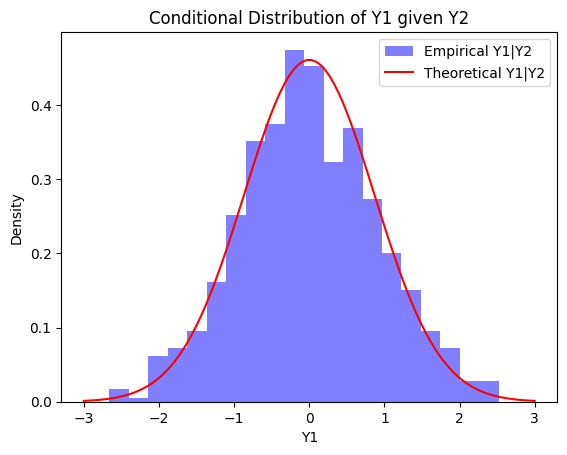

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Parameters for the multivariate normal distribution
mean = [0, 0]  # Mean vector
covariance_matrix = [[1, 0.5], [0.5, 1]]  # Covariance matrix

# Number of samples to generate
num_samples = 1000

# Generate random samples from multivariate normal distribution
samples = np.random.multivariate_normal(mean, covariance_matrix, num_samples)

# Extract Y1 and Y2 samples
Y1_samples = samples[:, 0]
Y2_samples = samples[:, 1]

# Define range of Y2 values for conditioning
y2_lower = -1
y2_upper = 1

# Filter Y1 samples based on Y2 values within the defined range
conditioned_Y1_samples = Y1_samples[(Y2_samples >= y2_lower) & (Y2_samples <= y2_upper)]

# Plot empirical distribution of conditioned Y1
plt.hist(conditioned_Y1_samples, bins=20, density=True, alpha=0.5, color='b', label='Empirical Y1|Y2')

# Plot theoretical conditional distribution of Y1 given Y2
conditional_Y1_given_Y2 = multivariate_normal(mean[0] + covariance_matrix[0][1] / covariance_matrix[1][1] * ((y2_lower + y2_upper) / 2 - mean[1]),
                                               covariance_matrix[0][0] - covariance_matrix[0][1] * covariance_matrix[1][0] / covariance_matrix[1][1])

y1_values = np.linspace(-3, 3, 100)
plt.plot(y1_values, conditional_Y1_given_Y2.pdf(y1_values), 'r-', label='Theoretical Y1|Y2')

plt.xlabel('Y1')
plt.ylabel('Density')
plt.title('Conditional Distribution of Y1 given Y2')
plt.legend()

plt.show()
